# Import Libraries

In [59]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from collections import deque
from datetime import datetime
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

# Import Datasets

In total, there are six datasets, the first four of them are the training data, while remains are the testing data.
<br><br>
But, in this case, the datasets are presented in uncommon format. So, once we have successfully imported all the datasets and assigned them to variables, then we will fix the format before further processing.  

In [4]:
df1_dataset = pd.read_csv('data/combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating', 'Date'])
# df2_dataset = pd.read_csv('data/combined_data_2.txt', header = None, names = ['Cust_Id', 'Rating', 'Date'])
# df3_dataset = pd.read_csv('data/combined_data_3.txt', header = None, names = ['Cust_Id', 'Rating', 'Date'])
# df4_dataset = pd.read_csv('data/combined_data_4.txt', header = None, names = ['Cust_Id', 'Rating', 'Date'])

prb_dataset = pd.read_csv("data/probe.txt", names=['Cust_Id'])
qlf_dataset = pd.read_csv("data/qualifying.txt", names=['Cust_Id', 'Date'])

# Data Viewing

Although the format is presented in an uncommon way, fortunately the implementation is the same for all datasets. So, all we have to do is create a function (repairFormat(data)) that can convert the format for all the datasets.

In [5]:
def repairFormat(data):
    # gather all movie ids and indices by using try and except which the id will be recognized 
    # as long as it outputs error when the value is trying to be converted into number (":")
    movie_indices = []
    movie_ids = []
    for i in range(data.shape[0]):
        try:
            int(data["Cust_Id"][i])
        except ValueError:
            movie_indices.append(i)
            movie_ids.append(data["Cust_Id"][i][:-1])

    # concatenating each data, categorized by the movie id
    newData = []
    length = len(movie_indices)
    for i in range(length):
        if i != length-1:
            # append all columns except movie_id
            tobeConcatenated = [
                pd.Series(data[col].iloc[movie_indices[i]+1:movie_indices[i+1]].values.flatten()) for col in data.columns
            ]
            
            # append movie_id column 
            tobeConcatenated.append(
                pd.Series([movie_ids[i] for j in range(movie_indices[i+1]-(movie_indices[i]+1))])
            )
            
            # concatenate all columns
            newData.append(pd.concat([
                dataCol for dataCol in tobeConcatenated
            ], axis=1))
        else:
            # append all columns except movie_id
            tobeConcatenated = [
                pd.Series(data[col].iloc[movie_indices[i]+1:data.shape[0]].values.flatten()) for col in data.columns
            ]
            
            # append movie_id column 
            tobeConcatenated.append(pd.Series([movie_ids[i] for j in range(data.shape[0]-(movie_indices[i]+1))]))
            
            # concatenate all columns
            newData.append(pd.concat([
                dataCol for dataCol in tobeConcatenated
            ], axis=1))
            
    # returning the concatenated data
    concatenatedData = pd.concat(newData, ignore_index=True)
    print(f"Because the number of movie ids are {len(movie_ids)},")
    print(f"so the number of concatenated data right now is:")
    print(f"{data.shape[0]} (your data length) - {len(movie_ids)} (number of movie ids) = {concatenatedData.shape[0]}")
    withCols = {
        data.columns[i]: concatenatedData[i] for i in range(len(data.columns))
    }
    withCols["Movie_Id"] = concatenatedData.iloc[:, -1]
    return pd.DataFrame(withCols)

Down below are the before and after formating of dataset df.

In [6]:
df1_dataset.drop("Date", axis=1).head(9)

,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0
5,823519,3.0
6,893988,3.0
7,124105,4.0
8,1248029,3.0


In [7]:
df = repairFormat(df1_dataset.drop("Date", axis=1).iloc[:100000, :])
df

Because the number of movie ids are 30,
so the number of concatenated data right now is:
100000 (your data length) - 30 (number of movie ids) = 99970


,Cust_Id,Rating,Movie_Id
0,1488844,3.0,1
1,822109,5.0,1
2,885013,4.0,1
3,30878,4.0,1
4,823519,3.0,1
...,...,...,...
99965,735848,4.0,30
99966,254710,4.0,30
99967,865725,4.0,30
99968,568153,3.0,30


Down below are the before and after formating of dataset prb.

In [8]:
prb_dataset.head(9)

,Cust_Id
0,1:
1,30878
2,2647871
3,1283744
4,2488120
5,317050
6,1904905
7,1989766
8,14756


In [9]:
prb = repairFormat(prb_dataset.iloc[:100000, :])
prb

Because the number of movie ids are 1354,
so the number of concatenated data right now is:
100000 (your data length) - 1354 (number of movie ids) = 98646


,Cust_Id,Movie_Id
0,30878,1
1,2647871,1
2,1283744,1
3,2488120,1
4,317050,1
...,...,...
98641,2397845,11283
98642,2470650,11283
98643,1256650,11283
98644,269304,11283


Down below are the before and after formating of dataset qlf.

In [10]:
qlf_dataset.drop("Date", axis=1).head(9)

,Cust_Id
0,1:
1,1046323
2,1080030
3,1830096
4,368059
5,802003
6,513509
7,1086137
8,428698


In [11]:
qlf = repairFormat(qlf_dataset.drop("Date", axis=1).iloc[:100000, :])
qlf

Because the number of movie ids are 796,
so the number of concatenated data right now is:
100000 (your data length) - 796 (number of movie ids) = 99204


,Cust_Id,Movie_Id
0,1046323,1
1,1080030,1
2,1830096,1
3,368059,1
4,802003,1
...,...,...
99199,992857,10730
99200,2152902,10730
99201,2268208,10730
99202,884439,10730


But, for the convenience of processing the data, I think it is better for us to convert all number data to be integer as there are some of library functions that need number type of data.

In [18]:
df = df.astype("int32")
prb = prb.astype("int32")
qlf = qlf.astype("int32")

# Data Cleaning 

Right now, once we have converted the format, the first thing we are going to do is to clean the data.
<br><br>
Down below is a function that requires a dataset in order to return the number of null values, its number of unique elements, and its number of duplicated values.

In [12]:
def dirty_check(df):
    for col in df.columns:
        print(f"{col} has {df[col].isnull().sum()} null values.")
        print(f"{col} has {df[col].nunique()} unique elements.\n")
        
    evaluatedColumn = ["Cust_Id", "Movie_Id"]
    print(f"This dataset has {df.duplicated(evaluatedColumn).sum()} duplicated values")

In [13]:
print("- - - Dirty Check on dataset df - - -\n")
dirty_check(df)
print()
print()
print()
print()

print("- - - Dirty Check on dataset prb - - -\n")
dirty_check(prb)
print()
print()
print()
print()

print("- - - Dirty Check on dataset qlf - - -\n")
dirty_check(qlf)

- - - Dirty Check on dataset df - - -

Cust_Id has 0 null values.
Cust_Id has 81472 unique elements.

Rating has 0 null values.
Rating has 5 unique elements.

Movie_Id has 0 null values.
Movie_Id has 30 unique elements.

This dataset has 0 duplicated values




- - - Dirty Check on dataset prb - - -

Cust_Id has 0 null values.
Cust_Id has 89091 unique elements.

Movie_Id has 0 null values.
Movie_Id has 1354 unique elements.

This dataset has 0 duplicated values




- - - Dirty Check on dataset qlf - - -

Cust_Id has 0 null values.
Cust_Id has 90269 unique elements.

Movie_Id has 0 null values.
Movie_Id has 796 unique elements.

This dataset has 0 duplicated values


From the result shown above, I think all the datasets are clear to go, as we can see that for each dataset come up with good result, such as 0 number of null values.

# Data Training and Fitting

In this process, we will train our data and evaluate the best number of components (dimensionality reduction) to be used, in order to get highest accuracy.
<br><br>
From the code shown below, we define two functions, first is used to give us accuracy, and second is to give us a visualization using boxplot (to determine best number of components to be used). 

In [16]:
def getAccuracy(
    X, y, nc=2,
    model=LogisticRegression(), cv=RepeatedStratifiedKFold(n_splits=9, n_repeats=3, random_state=99), 
    scoring='accuracy'
):    
    # define pipeline
    pipeline = Pipeline(steps=[
        ('svd', TruncatedSVD(n_components=nc)), ('m', model)
    ])
    n_scores = abs(cross_val_score(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1))
    
    return np.mean(n_scores), np.std(n_scores), n_scores


def showBoxplot(data, showmeans=True, title=None):
    plt.figure(figsize=(15,9))
    sns.boxplot(
        data,
        showmeans=showmeans,
        meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},
        palette="Blues",
    ).set(title=title)

But, what are the components? The columns? The number is so small!! The answer is we can claim some inputs using csr_matrix as the data we use is sparse data.
<br><br>
So, the code shown below is proposed to return a sparse matrix.

In [19]:
dfSparse = csr_matrix((df.Rating.values, ([i for i in range (df.shape[0])], df.Movie_Id.values)))


print(f"The shape of the sparse matrix is: {dfSparse.shape}")
us, mv = dfSparse.shape
elem = dfSparse.count_nonzero()

print(f"While, the sparsity is: {(  (1-(elem/(us*mv))) * 100)}%")

The shape of the sparse matrix is: (99970, 31)
While, the sparsity is: 96.7741935483871%


Right now, because the number of columns (components) are 31, we will test the accuracy given by using 1 to 31 number of components. 

In [20]:
results = []
for i in range(1, 32):
    theAccuracy = getAccuracy(
            dfSparse,
            df["Rating"], 
            nc=i
    )
    results.append(
        theAccuracy
    )
    
    if i != 1:
        print(f"By using {i} components, we get:")
    else:
        print(f"By using {i} component, we get:")
        
    print(f"Accuracy: {theAccuracy[0]}")
    print(f"Std: {theAccuracy[1]}\n")

By using 1 component, we get:
Accuracy: 0.4442532531899364
Std: 0.0035540338376746873

By using 2 components, we get:
Accuracy: 0.4362208648696837
Std: 0.0037893188213222718

By using 3 components, we get:
Accuracy: 0.47527259344750017
Std: 0.0035529140975650015

By using 4 components, we get:
Accuracy: 0.5378013430567677
Std: 0.003265992427139055

By using 5 components, we get:
Accuracy: 0.5378013430567677
Std: 0.003265992427139055

By using 6 components, we get:
Accuracy: 0.5458437566924369
Std: 0.0032551031865054435

By using 7 components, we get:
Accuracy: 0.580140898981741
Std: 0.019369457360520936

By using 8 components, we get:
Accuracy: 0.5817845382770018
Std: 0.00284591797461158

By using 9 components, we get:
Accuracy: 0.6409990484740068
Std: 0.009336416569986907

By using 10 components, we get:
Accuracy: 0.7795338707562826
Std: 0.0019071654136533576

By using 11 components, we get:
Accuracy: 0.7888266615075379
Std: 0.00170646149162265

By using 12 components, we get:
Accurac

We will now visualize the results using boxplot.
<br><br>
From the graph shown below, we can see that from $x=19$ to $x=31$ the fluctuation range is not as extreme as other x's. In this case, I will just choose $x=27$, which is in the middle range for the predicting process.

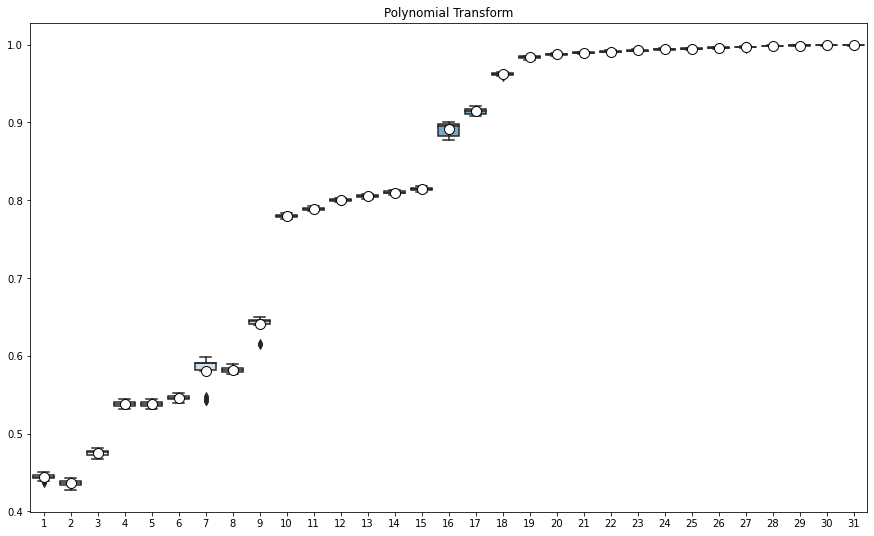

In [22]:
customDataPoly = pd.DataFrame({
    str(i+1): results[i][-1] for i in range(len(results))
})

showBoxplot(customDataPoly, title="Polynomial Transform")

# Predicting and RMSE Score

Now, for the last process, once we have determined the best number of components to be used, we will do predicting, and then calculating our RMSE in order to measure the accuracy.
<br><br>
But, before we go to that process, we still have to sparse our test data, which is in this case we will just use some number of data from the very last.


In [49]:
dfTest = repairFormat(df1_dataset.drop("Date", axis=1).iloc[-100000:, :].reset_index())
dfTest.drop("index", axis=1, inplace=True)
dfTest = df.astype('int32')
dfTest

Because the number of movie ids are 20,
so the number of concatenated data right now is:
100000 (your data length) - 20 (number of movie ids) = 80532


,Cust_Id,Rating,Movie_Id
0,1488844,3,1
1,822109,5,1
2,885013,4,1
3,30878,4,1
4,823519,3,1
...,...,...,...
99965,735848,4,30
99966,254710,4,30
99967,865725,4,30
99968,568153,3,30


Then, because in the end we will try to get our RMSE, so we have to gather the Y (rating) values.

In [58]:
actual = dfTest.Rating.values
actual

array([3, 5, 4, ..., 4, 3, 4])

In predicting, of course we need the input of predicting data, so right now we have to sparse our dfTest data.

In [51]:
dfTestSparse = csr_matrix((dfTest.Rating.values, ([i for i in range (dfTest.shape[0])], dfTest.Movie_Id.values)))


print(f"The shape of the sparse matrix is: {dfTestSparse.shape}")
us, mv = dfTestSparse.shape
elem = dfTestSparse.count_nonzero()

print(f"While, the sparsity is: {(  (1-(elem/(us*mv))) * 100)}%")

The shape of the sparse matrix is: (99970, 31)
While, the sparsity is: 96.7741935483871%


Predicting. . . which then we get an array contains the Y (rating) values generated from the process.

In [62]:
X, y = dfSparse, df["Rating"]

# define the model
steps = [('svd', TruncatedSVD(n_components=27)), ('m', LogisticRegression())]
model = Pipeline(steps=steps)

# fit the model on the whole dataset
model.fit(X, y)

# make a single prediction
row = dfTestSparse
yhat = model.predict(row)
print(f'Predicted Result: \n{yhat}')

Predicted Result: 
[3 5 4 ... 4 3 4]


C:\Users\Jason Caleb\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Right now, for the last process, we will evaluate our predicting model by calculating our RMSE score.

In [61]:
MSE = np.square(np.subtract(actual,yhat)).mean()   

rsme = math.sqrt(MSE)
print(f"Root Mean Square Error: {rsme}")

Root Mean Square Error: 0.11341895413795405


From the result shown above, we can conclude then if our predicting model is good enough as we get the score not so far from 0. 